# Exploration_6
## Movie Text Review Analysis (Korean ver.)
---
* 다양한 방법으로 Text Classification task를 성공적으로 구현하기 - 3가지 이상의 모델 시도
* gensim을 활용하여 자체학습된 혹은 사전학습된 Embedding layer 분석하기 - gensim의 유사단어 찾기를 활용하여 자체학습한 Embedding과 사전학습 Embedding을 적절히 분석
* 한국어 Word2Vec을 활용하여 가시적인 성능향상 달성하기 - 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성

### 데이터 준비와 확인

In [1]:
import pandas as pd

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [2]:
# 훈련데이터 5개만 알아보기
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
# 마찬가지로 테스트데이터 5개만 알아보기
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 데이터로더 구성
* 데이터의 중복 제거
* NaN 결측지 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전 word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print('훈련 샘플 개수 : {}, 테스트 개수 : {}'.format(len(X_train), len(X_test)))
print('word_to_index : ', len(word_to_index))

훈련 샘플 개수 : 146182, 테스트 개수 : 49157
word_to_index :  9997


In [5]:
print(X_train[0]) # 1번째 리뷰데이터
print('라벨 : ', y_train[0]) # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이 : ', len(X_train[0]))
print('2번째 리뷰 문장 길이 : ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨 :  0
1번째 리뷰 문장 길이 :  10
2번째 리뷰 문장 길이 :  17


In [6]:
word_to_index['<PAD>'] = 0 # 패딩
word_to_index['<BOS>'] = 1 # 모든 문장의 시작
word_to_index['<UNK>'] = 2 # Unknown

In [7]:
# index : word 형태의 딕셔너리 생성
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [9]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨 : ', y_train[0])

더 빙 . . 진짜 짜증 나 네요 목소리
라벨 :  0


### 모델 구성을 위한 데이터 분석 및 가공
* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [10]:
total_data_text = list(X_train) + list(X_test)
# 텍스트 데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를 들어, 최대 길이를 (평균 + 2x표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [11]:
# 문장길이를 맞춰주기 위해 문장 끝에 padding을 추가해준다.
import tensorflow as tf
import os

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                          value=word_to_index['<PAD>'],
                                                          padding='post',
                                                          maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                          value=word_to_index['<PAD>'],
                                                          padding='post',
                                                          maxlen=maxlen)
print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


In [12]:
# 훈련 데이터 약 1/10을 validation set으로 사용
X_val = X_train[:14000]
y_val = y_train[:14000]

# validation set을 제외한 나머지는 모두 훈련 데이터로 사용
partial_X_train = X_train[14000:]
partial_y_train = y_train[14000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(132182, 41)
(132182,)


### 모델 구성 및 validation set 구성
   * 모델은 3가지 이상 다양하게 구성하여 실험해 보기  
   
### 모델 훈련 개시
### Loss, Accuracy 그래프 시각화

In [13]:
vocab_size = 10000 # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 5 # 워드 벡터의 차원수

#### 1. GlobalMaxPooling1D layer 하나만 사용

In [14]:
# GlobalMaxPooling1D layer 하나만 사용하는 모델 설계

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 5)           50000     
_________________________________________________________________
global_max_pooling1d (Global (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 8)                 48        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 50,057
Trainable params: 50,057
Non-trainable params: 0
_________________________________________________________________


In [15]:
# GlobalMaxPooling1D layer 모델 학습

model.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])
epochs = 5

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val,y_val),
                    verbose=1)

Epoch 1/5
259/259 [==============================] - 2s 4ms/step - loss: 0.6450 - accuracy: 0.6493 - val_loss: 0.5599 - val_accuracy: 0.7642
Epoch 2/5
259/259 [==============================] - 1s 3ms/step - loss: 0.5073 - accuracy: 0.8064 - val_loss: 0.4696 - val_accuracy: 0.8225
Epoch 3/5
259/259 [==============================] - 1s 3ms/step - loss: 0.4426 - accuracy: 0.8377 - val_loss: 0.4362 - val_accuracy: 0.8260
Epoch 4/5
259/259 [==============================] - 1s 3ms/step - loss: 0.4056 - accuracy: 0.8491 - val_loss: 0.4191 - val_accuracy: 0.8277
Epoch 5/5
259/259 [==============================] - 1s 3ms/step - loss: 0.3801 - accuracy: 0.8563 - val_loss: 0.4096 - val_accuracy: 0.8280


In [16]:
# GlobalMaxPooling1D layer 모델 평가

results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.4189 - accuracy: 0.8274
[0.41894859075546265, 0.8273897767066956]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


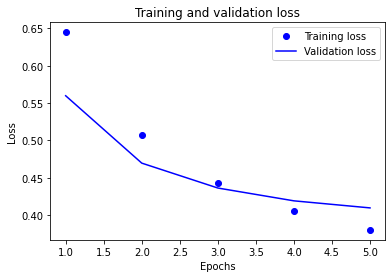

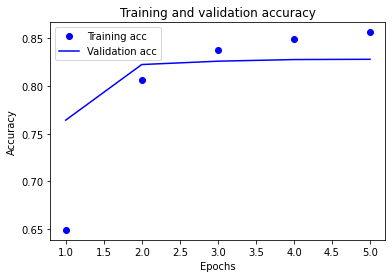

In [17]:
# GlobalMaxPooling1D layer 모델

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt
%matplotlib inline

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Loss 그래프

 # "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
 # b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Accuracy 그래프

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

* Training and Validation Loss를 그려보면, 몇 epoch까지의 트레이닝이 적절한지 최적점을 추정해 볼 수 있다.
* Validation Loss 그래프가 Training Loss와 이격이 발생하게 되면 더 이상의 트레이닝은 무의미해진다.
* 따라서 epoch을 5로 정해주었다.
* 마찬가지로 Training and Validation Accuracy도 그려 유사한 인사이트를 얻을 수 있었다.

#### 2. LSTM

In [18]:
# LSTM 모델 설계
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 5)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 448       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 50,529
Trainable params: 50,529
Non-trainable params: 0
_________________________________________________________________


In [19]:
# LSTM 모델 학습
model.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])
epochs = 5

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val,y_val),
                    verbose=1)

Epoch 1/5
259/259 [==============================] - 4s 7ms/step - loss: 0.6488 - accuracy: 0.5750 - val_loss: 0.4311 - val_accuracy: 0.8161
Epoch 2/5
259/259 [==============================] - 1s 5ms/step - loss: 0.3703 - accuracy: 0.8409 - val_loss: 0.3451 - val_accuracy: 0.8516
Epoch 3/5
259/259 [==============================] - 1s 5ms/step - loss: 0.3294 - accuracy: 0.8612 - val_loss: 0.3429 - val_accuracy: 0.8526
Epoch 4/5
259/259 [==============================] - 1s 5ms/step - loss: 0.3163 - accuracy: 0.8665 - val_loss: 0.3424 - val_accuracy: 0.8511
Epoch 5/5
259/259 [==============================] - 1s 5ms/step - loss: 0.3101 - accuracy: 0.8694 - val_loss: 0.3462 - val_accuracy: 0.8484


In [20]:
# LSTM 모델 평가
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.3574 - accuracy: 0.8457
[0.3574348986148834, 0.8457188010215759]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


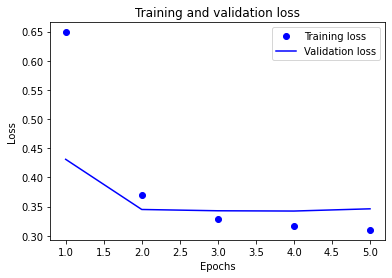

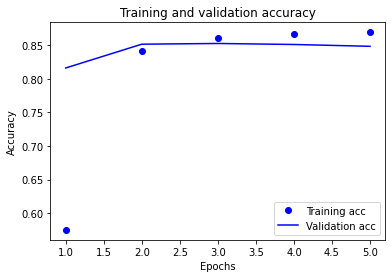

In [21]:
# LSTM 모델
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Loss 그래프
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Accuracy 그래프
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 3. 1-D CNN

In [22]:
# 1-D CNN 모델 설계
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 5)           50000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          576       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [23]:
# 1-D CNN 모델 학습
model.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])
epochs = 5

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val,y_val),
                    verbose=1)

Epoch 1/5
259/259 [==============================] - 3s 5ms/step - loss: 0.5133 - accuracy: 0.7325 - val_loss: 0.3754 - val_accuracy: 0.8319
Epoch 2/5
259/259 [==============================] - 1s 4ms/step - loss: 0.3458 - accuracy: 0.8528 - val_loss: 0.3496 - val_accuracy: 0.8481
Epoch 3/5
259/259 [==============================] - 1s 4ms/step - loss: 0.3164 - accuracy: 0.8677 - val_loss: 0.3479 - val_accuracy: 0.8473
Epoch 4/5
259/259 [==============================] - 1s 4ms/step - loss: 0.2986 - accuracy: 0.8760 - val_loss: 0.3499 - val_accuracy: 0.8451
Epoch 5/5
259/259 [==============================] - 1s 4ms/step - loss: 0.2818 - accuracy: 0.8847 - val_loss: 0.3490 - val_accuracy: 0.8493


In [24]:
# 1-D CNN 모델 평가
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.3536 - accuracy: 0.8493
[0.3535749018192291, 0.8493195176124573]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


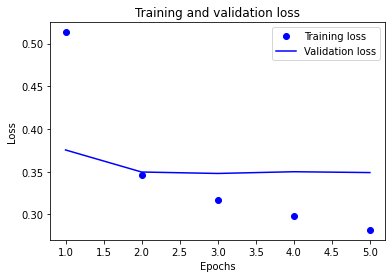

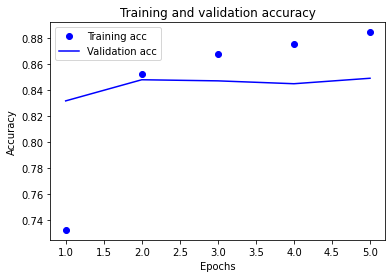

In [25]:
# 1-D CNN 모델 
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Loss 그래프# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Accuracy 그래프
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Model | Loss | Accuracy
------|------|---------
GlobalMaxPooling1D | 0.418 | 0.827
LSTM | 0.357 | 0.845
1-D CNN | 0.353 | 0.849

### 학습된 Embedding 레이어 분석

In [26]:
# 학습된 Embedding layer 분석

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 5)


In [27]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [28]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("사랑")

[('어울려요', 0.9880425333976746),
 ('슬픈', 0.9876216650009155),
 ('충만', 0.9873772859573364),
 ('살린', 0.9869508743286133),
 ('쩐', 0.9845016002655029),
 ('잘생긴', 0.9842177629470825),
 ('풀어낸', 0.9838762283325195),
 ('니까', 0.9822097420692444),
 ('이토록', 0.9818570613861084),
 ('거듭', 0.9816185235977173)]

* gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 wordvector로 활용하였다.
* wordvector가 의미 벡터 공간상에 유의미하게 학습되었는지 확인하기 위해 "사랑"이라는 단어를 주고 이와 가장 유사한 단어와 그 유사도를 확인하였다.
* "사랑"이라는 단어와 유사한 단어를 그리 잘 찾았다고 느껴지지 않는다.
* 분류 태스크를 잠깐 학습한 것만으로는 wordvector가 유의미하게 학습되기는 어려운 것 같다.

### 한국어 Word2Vec Embedding 활용하여 성능 개선

In [29]:
# 한국어 Word2Vec Embedding 활용하여 성능 개선

import gensim
from gensim.models import Word2Vec

word2vec_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['영화']
vector.shape

/tmp/ipykernel_639/2680794339.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['영화']


(200,)

In [30]:
word2vec.most_similar("사랑")

/tmp/ipykernel_639/2258360420.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  word2vec.most_similar("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

* 한국어 Word2Vec 임베딩을 활용한 경우 "사랑"이란 단어와 유사한 단어를 앞선 경우보다 훨씬 잘 찾는다.

In [31]:
vocab_size = 10000 
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4, vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_639/3625563249.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_639/3625563249.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


* 다음 링크 (https://github.com/Kyubyong/wordvectors) 에서 적절한 ko.bin(Korean word2vec)을 찾아 이용하였다. 
* pip install --upgrade gensim==3.8.3을 Cloud shell에 입력해주어 gensim 버전을 3.8.3으로 낮춰 오류가 나지 않도록 하였다.

#### LSTM 모델로 훈련

In [32]:
from tensorflow.keras.initializers import Constant
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                    word_vector_dim, 
                                    embeddings_initializer=Constant(embedding_matrix), 
                                    input_length=maxlen,
                                    trainable=True))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
epochs = 5

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
259/259 [==============================] - 5s 15ms/step - loss: 0.5525 - accuracy: 0.6898 - val_loss: 0.3904 - val_accuracy: 0.8274
Epoch 2/5
259/259 [==============================] - 4s 14ms/step - loss: 0.3479 - accuracy: 0.8478 - val_loss: 0.3267 - val_accuracy: 0.8562
Epoch 3/5
259/259 [==============================] - 4s 14ms/step - loss: 0.2948 - accuracy: 0.8745 - val_loss: 0.3163 - val_accuracy: 0.8636
Epoch 4/5
259/259 [==============================] - 4s 14ms/step - loss: 0.2644 - accuracy: 0.8906 - val_loss: 0.3262 - val_accuracy: 0.8615
Epoch 5/5
259/259 [==============================] - 4s 14ms/step - loss: 0.2420 - accuracy: 0.9011 - val_loss: 0.3206 - val_accuracy: 0.8679


In [34]:
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.3315 - accuracy: 0.8630
[0.3315325081348419, 0.8630103468894958]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


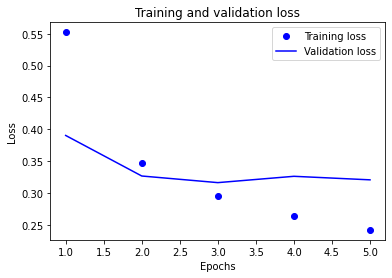

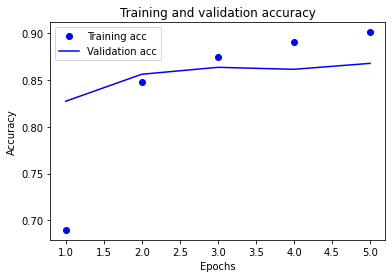

In [35]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Loss 그래프

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Accuracy 그래프

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

* LSTM 모델에 한국어 Word2Vec Embedding을 활용한 결과, 아래와 같이 loss, accuracy 성능이 개선된 것을 확인하였다.
* 앞선 경우와 마찬가지로, epoch이 커질 경우 training set에 과대적합되어 validation set에 적절한 예측을 하지 못한다.
* 따라서 epoch을 5로 지정해주었고, batch_size도 똑같은 맥락으로 과대적합을 방지하기 위하여 512로 지정해주었다.
* 그 결과, 정확도 약 86%를 달성할 수 있었다.

Embedding | Loss | Accuracy
----------|------|---------
학습된 Embedding | 0.357 | 0.845
한국어 Word2Vec Embedding | 0.331 | 0.863
     